In [1]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [2]:
import os 
import tarfile
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

if os.path.exists("/content/drive/MyDrive/Colab Notebooks/"):
    COLAB_PATH = "/content/drive/MyDrive/Colab Notebooks/大伯 - ML_Code"
else:
    COLAB_PATH = "/content/drive/MyDrive/UTKFace-Code/"
os.chdir(COLAB_PATH)

!pwd
!ls -l

/content/drive/MyDrive/Colab Notebooks/大伯 - ML_Code
total 4522103
-rw------- 1 root root    8191848 Jul  4  2021 best_cifar10_weights.h5
-rw------- 1 root root   90251248 Aug 15 16:49 best_fmnist_weights.h5
-rw------- 1 root root   12866776 Nov  2 17:03 best_race_weights.h5
-r-------- 1 root root 4405025375 Jul 25  2018 CASIA-WebFace.zip
drwx------ 2 root root       4096 Aug 15 11:16 cifar-10-batches-py
-rw------- 1 root root    1104376 Oct  6 23:41 cifar10_classifier.ipynb
-rw------- 1 root root       3091 Jun 30  2021 cifar10_cnn_orig.py
-rw------- 1 root root      14757 Aug  6 22:33 cifar10_convert_img.ipynb
-rw------- 1 root root     179617 Oct  6 23:41 fMnist_classifier.ipynb
drwx------ 2 root root       4096 Aug 15 11:16 hyper_dir
drwx------ 2 root root       4096 Aug 15 11:16 model_weights
-rw------- 1 root root     222380 Jul  4  2021 ResNet9_128_batch_acc_0.9332_fig.png
-rw------- 1 root root     220955 Jul  2  2021 ResNet9_128_batch_acc_0.9392_fig.png
-rw------- 1 root root  

In [4]:
# Retreive UTKFace data and drop missing data

%time utk_face = pd.Series(os.listdir("UTKFace"))

img = plt.imread(os.getcwd()+"/UTKFace/"+utk_face[0], "jpg")
print(f"\nUTKFace Total Imgs: {utk_face.count()}, Shape: {img.shape}")
print(f"UTKFace have: {utk_face.isnull().sum()} NaN values.\n")


# Other: (missing race)
other = utk_face[utk_face.str.match(r"^[0-1]?\d?\d+_[0-1]_[0-4]+_") == False]
print(f"Other img(missing race): {other.count()}\n\n{other}\n")
print("----------------------------------------------")


# UTKFace total data exclude Other(missing race) 
utkface_drop_other = np.setdiff1d(utk_face, other)
print(f"new_utkface length: {len(utkface_drop_other)}\n")
print(utkface_drop_other)


# Get race labels
def parse_race(file):
    race_label = []
    for f in file:
        age, gender, race, _ = f.split("_")
        race_label.append(int(race))

    return np.array(race_label)

race_labels = parse_race(utkface_drop_other)
print(f"race_labels: {race_labels}")

CPU times: user 126 ms, sys: 31.9 ms, total: 158 ms
Wall time: 20.9 s

UTKFace Total Imgs: 23708, Shape: (200, 200, 3)
UTKFace have: 0 NaN values.

Other img(missing race): 3

3376     39_1_20170116174525125.jpg.chip.jpg
15800    61_1_20170109150557335.jpg.chip.jpg
15803    61_1_20170109142408075.jpg.chip.jpg
dtype: object

----------------------------------------------
new_utkface length: 23705

['100_0_0_20170112213500903.jpg.chip.jpg'
 '100_0_0_20170112215240346.jpg.chip.jpg'
 '100_1_0_20170110183726390.jpg.chip.jpg' ...
 '9_1_4_20170103200637399.jpg.chip.jpg'
 '9_1_4_20170103200814791.jpg.chip.jpg'
 '9_1_4_20170103213057382.jpg.chip.jpg']
race_labels: [0 0 0 ... 4 4 4]


UTKFace.h5 already exists.
CPU times: user 1min 4s, sys: 4.27 s, total: 1min 9s
Wall time: 1min 33s
23705


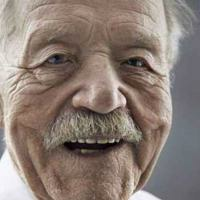

100_0_0_20170112213500903.jpg.chip.jpg


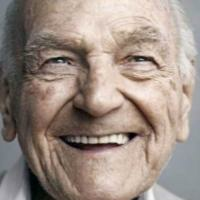

100_0_0_20170112215240346.jpg.chip.jpg


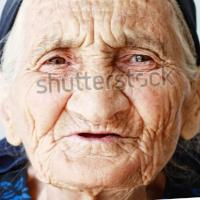

100_1_0_20170110183726390.jpg.chip.jpg


In [ ]:
# Convert UTKFace jpg imgs to hdf5, in order to speed up the reading speed of a large number of imgs.
import cv2
import h5py
from google.colab.patches import cv2_imshow


# method 1:  ** return BGR
# %time utkface_np = [tf.image.decode_image(tf.io.read_file("./UTKFace/"+name)).numpy() for name in utkface_drop_other]

# method 2:  ** return RGB
# %time utkface_np = [cv2.imread("./UTKFace/"+name) for name in utkface_drop_other]
# print(utkface_np[0])

# method 3: ** return BGR use container
# import multiprocessing as mp

# # os.cpu_count()
# cpu_count = len(os.sched_getaffinity(0))
# print(f"cpu available: {cpu_count}")

# # read img container
# class ImgIter:
#     def __init__(self, dataset):
#         self.dataset = dataset
    
#     def __iter__(self):
#         for i in self.dataset:
#             yield "./UTKFace/"+i


# class ConvertIter:
#     def __init__(self, map_data):
#         self.map_data = map_data
    
#     def __iter__(self):
#         for i in self.map_data:
#             yield tf.image.decode_image(i)


# def multi_process(data, cpu_available = cpu_count):
#     with mp.Pool(processes = cpu_available) as pool:
#         img_np = list(ConvertIter(pool.map(tf.io.read_file, ImgIter(data))))

#         return img_np

# utkface_np = multi_process(utkface_drop_other)


# storing jpg to hdf5
def convert_img_to_hdf5(path):
    with h5py.File(path, "w") as hf:
        for idx, (img, name) in enumerate(zip(utkface_np, utkface_drop_other)):
            hf.create_dataset(name = f"{name}", 
                              shape = img.shape,
                              data = img,
                              compression = "gzip",
                              compression_opts = 9
                              )
    
# convert_img_to_hdf5("./UTKFace.h5")


# unzip UTKFace.h5 gz and open UTKFace hdf5 to read numpy imgs

def unzip_tarfile(path):
    if os.path.exists(f"./{path}"):
        print(f"{path} already exists.")
    else:
        tar = tarfile.open(f"./{path}.tar.gz")
        tar.extractall()
        tar.close()
    
        print(f"{path}.tar.gz has been unzipped.")


def read_hdf5(file_path):
    unzip_tarfile(file_path)
    
    with h5py.File(f"./{file_path}", "r") as hf:
        utkface_dict = {name: np.asarray(img) for name, img in hf.items()}

    return utkface_dict

%time utkface_images = read_hdf5("UTKFace.h5")
print(len(utkface_images))

# plot img
for idx, (name, image) in enumerate(utkface_images.items()):
    if idx <= 2:
        # BGR to RGB
        cv2_imshow(image[..., ::-1].copy())
        print(name)
    else:
        break

In [5]:
# Using (Isolation Forest) for Anomaly(Outlier) Detection .

import cv2
from sklearn.ensemble import IsolationForest
import multiprocessing as mp

# os.cpu_count()
cpu_count = len(os.sched_getaffinity(0))
print(f"cpu available: {cpu_count}")


def quantify_image(image, bins=(4, 6, 3)):
	# compute a 3D color histogram over the image and normalize it
	hist = cv2.calcHist([image], [0, 1, 2], None, bins, 
    [0, 180, 0, 256, 0, 256])
	hist = cv2.normalize(hist, hist).flatten()
	
	return hist


class ImgIter:
    def __init__(self, dataset):
        self.dataset = dataset
    
    def __iter__(self):
        for i in self.dataset:
            yield "./UTKFace/"+i


class ConvertColorIter:
    def __init__(self, map_data):
        self.map_data = map_data
    
    def __iter__(self):
        for i in self.map_data:
            yield cv2.cvtColor(i, cv2.COLOR_BGR2RGB)


def multi_process_data(data, bins, cpu_available = cpu_count):
    quantify_data = []
    with mp.Pool(processes = cpu_available) as pool:
        img_data = list(ConvertColorIter(pool.map(cv2.imread, ImgIter(data))))

    for img in img_data:
        features = quantify_image(img, bins)
        quantify_data.append(features)

    return np.array(quantify_data), np.array(img_data)


# def load_data(data, bins):
#     img_data = []
#     quantify_data = []
#     for name in data:
#         img = cv2.imread("./UTKFace/"+name)
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#         img_data.append(img)
        
#         features = quantify_image(img, bins)
#         quantify_data.append(features)
    
#     return np.array(quantify_data), np.array(img_data)

quantify_data, utk_data = multi_process_data(utkface_drop_other, (3, 3, 3))


iso_clf = IsolationForest(n_estimators = 100, contamination = 0.01, random_state = 42)
iso_clf.fit(quantify_data)
y_predict = iso_clf.predict(quantify_data)
print(y_predict)

cpu available: 2
[1 1 1 ... 1 1 1]


In [6]:
print(np.sum(y_predict != 1))

238


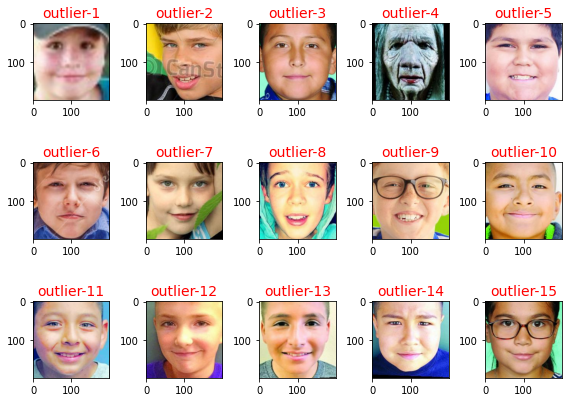

In [7]:
# plot outlier for anomaly detection(Isolation Forest)

plt.figure(figsize = (8, 6), tight_layout = True)
for i in range(0, sum(y_predict != 0)):
    if i <= 14:
        plt.subplot(3, 5, i+1)
        plt.title(f"outlier-{i+1}", fontsize = 14, color = "red")
        plt.imshow(utk_data[y_predict != 1][i])

In [8]:
# Dimentionality Reduction use t-SNE

from sklearn.manifold import TSNE

t_sne = TSNE(n_components = 2, random_state = 42)
reduced_utkface = t_sne.fit_transform(quantify_data)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [9]:
import matplotlib as mpl
from sklearn.preprocessing import MinMaxScaler
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

def plot_tsne_scatter(X, y, min_distance=0.05, images=None, figsize=(13, 10)):
    # Let's scale the input features so that they range from 0 to 1
    X_normalized = MinMaxScaler().fit_transform(X)
    # Now we create the list of coordinates of the digits plotted so far.
    # We pretend that one is already plotted far away at the start, to
    # avoid `if` statements in the loop below
    neighbors = np.array([[10., 10.]])
    # The rest should be self-explanatory
    plt.figure(figsize=figsize)
    cmap = mpl.cm.get_cmap("jet")
    digits = np.unique(y)
    for digit in digits:
        plt.scatter(X_normalized[y == digit, 0], X_normalized[y == digit, 1], c=[cmap(digit / 9)])
    plt.axis("off")
    ax = plt.gcf().gca()  # get current axes in current figure
    for index, image_coord in enumerate(X_normalized):
        closest_distance = np.linalg.norm(neighbors - image_coord, axis=1).min()
        if closest_distance > min_distance:
            neighbors = np.r_[neighbors, [image_coord]]
            if images is None:
                plt.text(image_coord[0], image_coord[1], str(int(y[index])),
                         color=cmap(y[index] / 9), fontdict={"weight": "bold", "size": 20})
            else:
                image = images[index].reshape(200, 200, 3)
                imagebox = AnnotationBbox(OffsetImage(image, cmap="binary"), image_coord)
                ax.add_artist(imagebox)

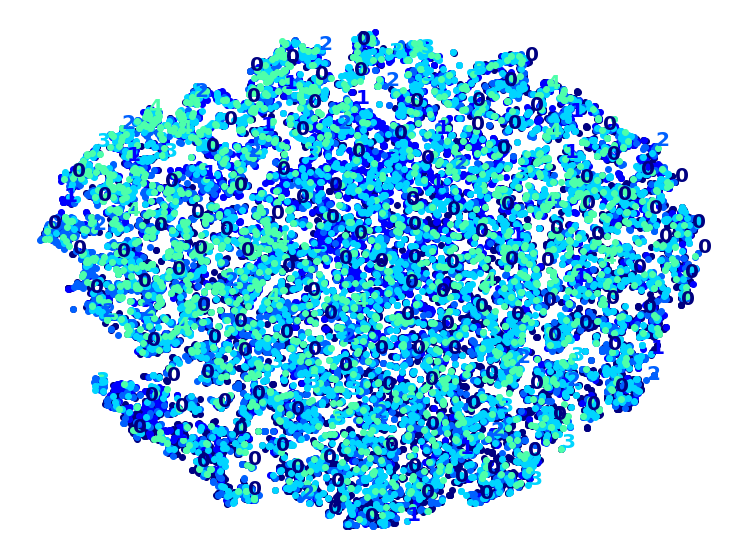

In [10]:
plot_tsne_scatter(reduced_utkface, race_labels)

In [12]:
plot_tsne_scatter(reduced_utkface, race_labels, images = utk_data, figsize = (75, 65))

Output hidden; open in https://colab.research.google.com to view.

In [20]:
!pip install umap-learn
!pip install holoviews bokeh holoviews datashader colorcet

     |████████████████████████████████| 15.8 MB 5.1 MB/s 
     |████████████████████████████████| 76 kB 4.8 MB/s 
     |████████████████████████████████| 133 kB 63.6 MB/s 
     |████████████████████████████████| 802 kB 70.1 MB/s 
     |████████████████████████████████| 802 kB 73.0 MB/s 
     |████████████████████████████████| 793 kB 53.1 MB/s 
     |████████████████████████████████| 793 kB 54.0 MB/s 
     |████████████████████████████████| 791 kB 60.1 MB/s 
     |████████████████████████████████| 786 kB 54.5 MB/s 
     |████████████████████████████████| 779 kB 59.5 MB/s 
     |████████████████████████████████| 778 kB 62.1 MB/s 
     |████████████████████████████████| 776 kB 60.3 MB/s 
     |████████████████████████████████| 769 kB 52.5 MB/s 
     |████████████████████████████████| 766 kB 53.2 MB/s 
     |████████████████████████████████| 1.0 MB 54.1 MB/s 
     |████████████████████████████████| 722 kB 62.8 MB/s 
     |████████████████████████████████| 722 kB 57.0 MB/s 
     |██████████

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


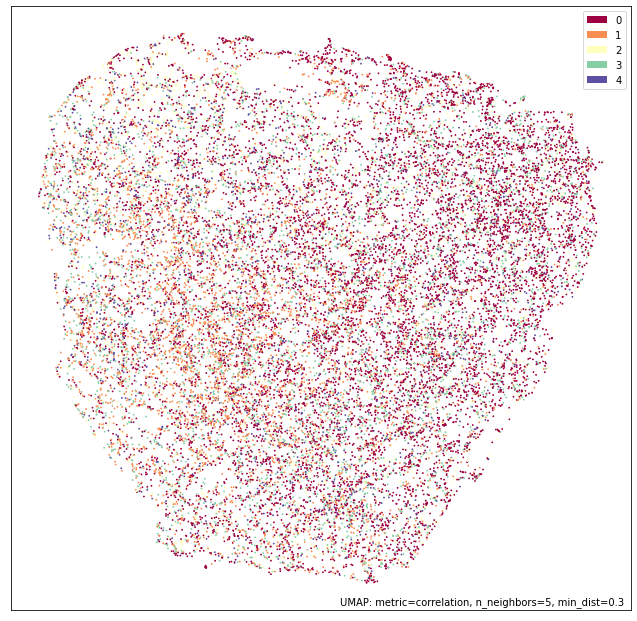

In [21]:
# Dimension Reduction use Uniform Manifold Approximation and Projection (UMAP)

import pandas as pd
import matplotlib.pyplot as plt
import umap
import umap.plot

mapper = umap.UMAP(n_neighbors=5,
                   min_dist=0.3,
                   metric='correlation').fit(quantify_data)
umap.plot.points(mapper, labels = race_labels)

In [ ]:
!pip install mediapipe

In [ ]:
# Clean UTKFace data using face detector. 
# 1. Drop a lot of data didn't detect human faces.
# 2. Drop some has only one eye data using face detector.

import shutil
import mediapipe as mp
mp_face_detector = mp.solutions.face_detection


# prepare DrawingSpec for drawing the face landmarks
mp_drawing = mp.solutions.drawing_utils
drawing_spec = mp_drawing.DrawingSpec(thickness = 1, circle_radius = 1)


# detect_human_faces_success = []
undetectable_images_of_human_faces = []

# human_faces_des = "./UTKFace-data-cleaning/human-faces/"
no_human_faces_des = "./UTKFace-data-cleaning/no-human-faces-ssd/"


def check_dir(path):
    if os.path.exists(path):
        print(f"{path} directory is exist !")
    else:
        os.makedirs(path)
        print(f"{path} directory is already built !")
        
# check_dir(human_faces_des)
check_dir(no_human_faces_des)


with mp_face_detector.FaceDetection(min_detection_confidence = 0.5, model_selection = 0) as face_detector:
    for idx, (name, image) in enumerate(utkface_images.items()):
        print(f"Processing img: {name} --> number: [{idx}]")

        # Convert BGR img to RGB -> cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # this utkface_images is already used to store RGB
        face_location = face_detector.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        
        # human face detected error(no human face or other reason) -> min_detection_confidence < 0.5
        if not face_location.detections:
            # move img to destination dir
            shutil.copy(f"./UTKFace/{name}", os.path.join(no_human_faces_des, name))
            undetectable_images_of_human_faces.append(image)

        # human face detected success -> min_detection_confidence >= 0.5
        else:
            # shutil.copy(f"./UTKFace/{name}", os.path.join(human_faces_des, name))
            # detect_human_faces_success.append(image)
            
            # Draw rectangle to face images, retreive 6 images
            if idx <= 5:
                copied_image = image.copy()
        
                for location in face_location.detections:
                    mp_drawing.draw_detection(copied_image, location)
                
                # BGR img to RGB
                cv2_imshow(copied_image[..., ::-1])
                print(f"Detected Image's name: {name}")

In [ ]:
len(os.listdir(no_human_faces_des))

In [ ]:
# !apt-get install build-essential cmake
# !apt-get install libopenblas-dev liblapack-dev 
# !pip3 install dlib

Reading package lists... Done
Building dependency tree       
Reading state information... Done
build-essential is already the newest version (12.4ubuntu1).
cmake is already the newest version (3.10.2-1ubuntu2.18.04.2).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
liblapack-dev is already the newest version (3.7.1-4ubuntu1).
libopenblas-dev is already the newest version (0.2.20+ds-4).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


./UTKFace-data-clean/no-human-faces-dlib/ directory is exist !
Processing img: 100_0_0_20170112213500903.jpg.chip.jpg
Number of faces detected: 1
Detect img_[0], Location detect --> Left: -27, Top: 15, Right: 180, Bottom: 201
Center detect --> Center: (77, 108)


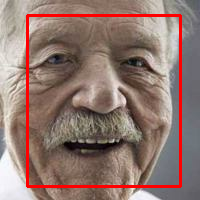

Processing img: 100_0_0_20170112215240346.jpg.chip.jpg
Number of faces detected: 1
Detect img_[0], Location detect --> Left: 15, Top: -26, Right: 201, Bottom: 180
Center detect --> Center: (108, 77)


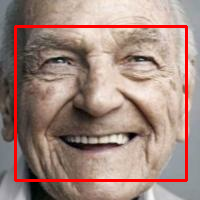

Processing img: 100_1_0_20170110183726390.jpg.chip.jpg
Number of faces detected: 1
Detect img_[0], Location detect --> Left: -27, Top: -26, Right: 180, Bottom: 180
Center detect --> Center: (77, 77)


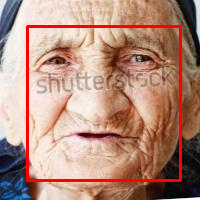

Processing img: 100_1_0_20170112213001988.jpg.chip.jpg
Number of faces detected: 1
Detect img_[0], Location detect --> Left: 15, Top: -26, Right: 201, Bottom: 180
Center detect --> Center: (108, 77)


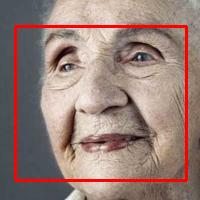

Processing img: 100_1_0_20170112213303693.jpg.chip.jpg
Number of faces detected: 1
Detect img_[0], Location detect --> Left: 15, Top: -26, Right: 201, Bottom: 180
Center detect --> Center: (108, 77)


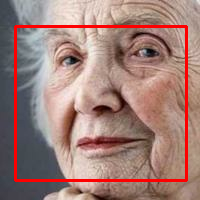

Processing img: 100_1_0_20170112215032192.jpg.chip.jpg
Number of faces detected: 1
Detect img_[0], Location detect --> Left: 12, Top: 12, Right: 167, Bottom: 167
Center detect --> Center: (90, 90)


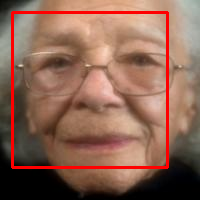

串流輸出內容已截斷至最後 5000 行。
Processing img: 65_0_1_20170120134639935.jpg.chip.jpg
Number of faces detected: 1
Processing img: 65_0_1_20170120222929626.jpg.chip.jpg
Number of faces detected: 1
Processing img: 65_0_1_20170120222944643.jpg.chip.jpg
Number of faces detected: 1
Processing img: 65_0_1_20170120223029947.jpg.chip.jpg
Number of faces detected: 1
Processing img: 65_0_1_20170120223219484.jpg.chip.jpg
Number of faces detected: 1
Processing img: 65_0_1_20170120223512324.jpg.chip.jpg
Number of faces detected: 1
Processing img: 65_0_1_20170120223824820.jpg.chip.jpg
Number of faces detected: 1
Processing img: 65_0_1_20170120224015174.jpg.chip.jpg
Number of faces detected: 1
Processing img: 65_0_2_20161219193311243.jpg.chip.jpg
Number of faces detected: 1
Processing img: 65_0_2_20170111205651706.jpg.chip.jpg
Number of faces detected: 1
Processing img: 65_0_2_20170112205356788.jpg.chip.jpg
Number of faces detected: 1
Processing img: 65_0_2_20170112205504482.jpg.chip.jpg
Number of faces detecte

In [ ]:
# Use dlib detector to clean

import shutil
import dlib

no_human_faces_dlib = "./UTKFace-data-cleaning/no-human-faces-dlib/"
print(f"{no_human_faces_dlib} directory is exist !") if os.path.exists(no_human_faces_dlib) else os.makedirs(no_human_faces_dlib)

undetectable_human_faces = []

detector = dlib.get_frontal_face_detector()

for idx, (name, image) in enumerate(utkface_images.items()):
    print(f"Processing img: {name} --> number: [{idx}]")
    img_to_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
    detects = detector(img_to_rgb, 1)
    print(f"Number of faces detected: {len(detects)}")

    # human face detected error(no human face or other reason)
    if len(detects) == 0:
        # move img to destination dir
        shutil.copy(f"./UTKFace/{name}", os.path.join(no_human_faces_dlib, name))
        undetectable_human_faces.append(image)

    else:
        # retrieve 6 imgs
        if idx <= 5:
            for i, d in enumerate(detects):
                print(f"Detect img_[{i}], Location detect --> Left: {d.left()}, Top: {d.top()}, Right: {d.right()}, Bottom: {d.bottom()}") 
                print(f"Center detect --> Center: {d.center()}")
                copied_img = img_to_rgb.copy()

                compare_min = lambda x, y: y if x > y else x
                reset_area = lambda a: a - compare_min(abs(d.left()), abs(d.top())) if a >= image.shape[0] else a
                cv2.rectangle(copied_img, (abs(d.left()), abs(d.top())), (reset_area(d.right()), reset_area(d.bottom())), (0, 0, 255), 2)
        
            cv2_imshow(copied_img)
            dlib.hit_enter_to_continue()

In [ ]:
len(undetectable_human_faces)

878

In [ ]:
!pip3 install mtcnn

./UTKFace-data-clean/no-human-faces-mtcnn/ directory is exist !
Face img: 100_0_0_20170112213500903.jpg.chip.jpg ---> number: [0]
Face img: 100_0_0_20170112215240346.jpg.chip.jpg ---> number: [1]
detect location box: [22, 0, 168, 196]
keypoints: {'left_eye': (61, 60), 'right_eye': (141, 61), 'nose': (97, 107), 'mouth_left': (61, 139), 'mouth_right': (136, 139)}
detect confidence: 0.9841361045837402


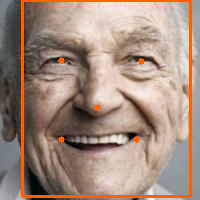

Face img: 100_1_0_20170110183726390.jpg.chip.jpg ---> number: [2]
Face img: 100_1_0_20170112213001988.jpg.chip.jpg ---> number: [3]
Face img: 100_1_0_20170112213303693.jpg.chip.jpg ---> number: [4]
detect location box: [40, 0, 163, 199]
keypoints: {'left_eye': (70, 59), 'right_eye': (144, 53), 'nose': (89, 100), 'mouth_left': (76, 145), 'mouth_right': (139, 141)}
detect confidence: 0.9747582674026489


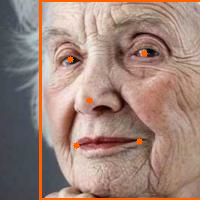

Face img: 100_1_0_20170112215032192.jpg.chip.jpg ---> number: [5]
Face img: 100_1_0_20170117195420803.jpg.chip.jpg ---> number: [6]
Face img: 100_1_0_20170119212053665.jpg.chip.jpg ---> number: [7]
detect location box: [10, 0, 173, 185]
keypoints: {'left_eye': (59, 58), 'right_eye': (140, 57), 'nose': (101, 104), 'mouth_left': (63, 136), 'mouth_right': (135, 137)}
detect confidence: 0.9963390827178955


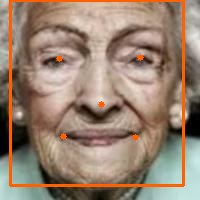

Face img: 100_1_2_20170105174847679.jpg.chip.jpg ---> number: [8]
detect location box: [15, 0, 171, 191]
keypoints: {'left_eye': (64, 59), 'right_eye': (142, 59), 'nose': (100, 95), 'mouth_left': (66, 137), 'mouth_right': (136, 139)}
detect confidence: 0.9960849285125732


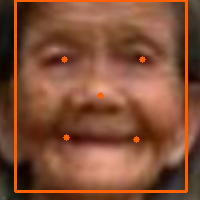

Face img: 100_1_2_20170112213615815.jpg.chip.jpg ---> number: [9]
Face img: 100_1_2_20170112222336458.jpg.chip.jpg ---> number: [10]
detect location box: [7, 0, 155, 186]
keypoints: {'left_eye': (58, 64), 'right_eye': (133, 63), 'nose': (100, 103), 'mouth_left': (65, 142), 'mouth_right': (126, 142)}
detect confidence: 0.9837154746055603


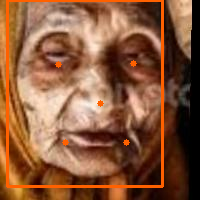

Face img: 101_0_0_20170112213500903.jpg.chip.jpg ---> number: [11]
Face img: 101_1_2_20170105174739309.jpg.chip.jpg ---> number: [12]
Face img: 103_0_2_20170112213001988.jpg.chip.jpg ---> number: [13]
detect location box: [9, 0, 158, 185]
keypoints: {'left_eye': (62, 57), 'right_eye': (135, 57), 'nose': (104, 101), 'mouth_left': (65, 138), 'mouth_right': (130, 139)}
detect confidence: 0.9957152009010315


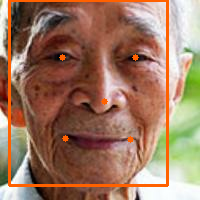

Streaming output truncated to the last 5000 lines.
Face img: 53_0_1_20170113174111826.jpg.chip.jpg ---> number: [18705]
Face img: 53_0_1_20170116024724425.jpg.chip.jpg ---> number: [18706]
Face img: 53_0_1_20170116191725055.jpg.chip.jpg ---> number: [18707]
Face img: 53_0_1_20170116192938845.jpg.chip.jpg ---> number: [18708]
Face img: 53_0_1_20170117181950281.jpg.chip.jpg ---> number: [18709]
Face img: 53_0_1_20170120222553113.jpg.chip.jpg ---> number: [18710]
Face img: 53_0_1_20170120222956787.jpg.chip.jpg ---> number: [18711]
Face img: 53_0_1_20170120223004304.jpg.chip.jpg ---> number: [18712]
Face img: 53_0_2_20170104210010763.jpg.chip.jpg ---> number: [18713]
Face img: 53_0_2_20170112215433623.jpg.chip.jpg ---> number: [18714]
Face img: 53_0_2_20170112221930338.jpg.chip.jpg ---> number: [18715]
Face img: 53_0_2_20170116192925824.jpg.chip.jpg ---> number: [18716]
Face img: 53_0_2_20170116192934154.jpg.chip.jpg ---> number: [18717]
Face img: 53_0_2_20170119205816456.jpg.chip.jpg --->

In [ ]:
# Use MTCNN detector to clean

import shutil
from mtcnn import MTCNN

# build dir
no_human_faces_mtcnn = "./UTKFace-data-cleaning/no-human-faces-mtcnn/"
print(f"{no_human_faces_mtcnn} directory is exist !") if os.path.exists(no_human_faces_mtcnn) else os.makedirs(no_human_faces_mtcnn)

undetectable_human_faces_mtcnn = []

# call mtcnn detector
detector = MTCNN()
conf_threshold = 0.9
counter = 0

for idx, (name, image) in enumerate(utkface_images.items()):
    print(f"UTKFace img: {name} ---> number: [{idx}]")
    img_to_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    copied_img = img_to_rgb.copy()
    
    face_info = detector.detect_faces(copied_img)
    
    if len(face_info) == 0:
        # move img to destination dir if not detected
        shutil.copy(f"./UTKFace/{name}", os.path.join(no_human_faces_mtcnn, name))
        undetectable_human_faces_mtcnn.append(image)

        continue

    else:    
        for info in face_info:
            # retrieve 6 imgs
            if counter <= 5:
                print(f"detect location box: {info['box']}")  #  box: (x, y, width, height)
                print(f"keypoints: {info['keypoints']}")  #  'nose', 'mouth_right', 'right_eye', 'left_eye', 'mouth_left'
                print(f"detect confidence: {info['confidence']}") 

                # confidence >= 0.9 --> detected success
                if info["confidence"] >= conf_threshold:

                    # draw a rectangle if it can be recognized 
                    x, y, width, height = info["box"]
                    cv2.rectangle(copied_img, (x, y), (x+width, y+height), (0, 97, 255), 2)
        
                    # draw facial features -> 'nose', 'mouth_right', 'right_eye', 'left_eye', 'mouth_left'
                    for key, features in info["keypoints"].items():
                        cv2.circle(copied_img, features, 3, (0, 97, 255), -1)
                    
                    counter += 1

                cv2_imshow(copied_img)

In [ ]:
no_human_faces_mtcnn = "./UTKFace-data-cleaning/no-human-faces-mtcnn/"
len(os.listdir(no_human_faces_mtcnn))

4643

mean_Less_than_100: 89


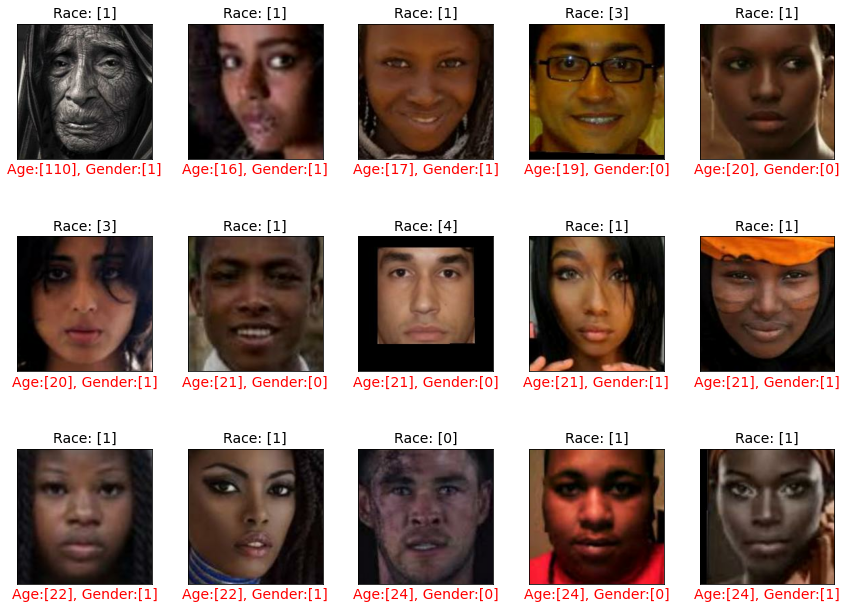

In [ ]:
# 3. Adjust some very dark data to higher brightness.
import matplotlib.pyplot as plt

# RGB 50 <= brightness <= 100 (range 0 ~ 255) 
# build counter
mean_Less_than_100 = 0
counter_A = 0
n_img = 15

# plot img
plt.figure(figsize = (12, 10), tight_layout = True)
for idx, (name, image) in enumerate(utkface_images.items()):
    if 50 <= np.mean(image) <= 55:
        # cv2_imshow -> BGR to RGB
        if mean_Less_than_100 < n_img:
            plt.subplot(3, 5, counter_A+1)
            plt.xticks([])
            plt.yticks([])
            plt.imshow(image.copy())
            plt.title(f'''Race: [{name.split("_")[2]}]''', fontsize = 14)
            plt.xlabel(f'''Age:[{name.split("_")[0]}], Gender:[{name.split("_")[1]}]''', fontsize = 14, color = "red")
            counter_A += 1
        mean_Less_than_100 += 1

print(f"mean_Less_than_100: {mean_Less_than_100}")

mean_Less_than_50: 96


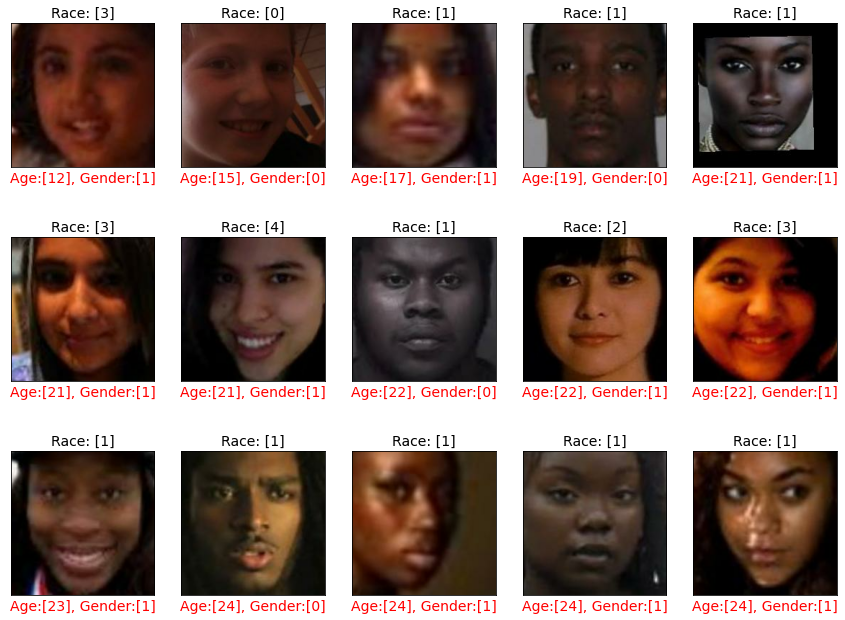

In [ ]:
# RGB brightness < 50 (range 0 ~ 255)
# build counter 
mean_Less_than_50 = 0
counter_B = 0

# plot img
plt.figure(figsize = (12, 10), tight_layout = True)
for idx, (name, image) in enumerate(utkface_images.items()):
    if np.mean(image) < 50:
        if mean_Less_than_50 < n_img:
            plt.subplot(3, 5, counter_B+1)
            plt.xticks([])
            plt.yticks([])
            plt.imshow(image.copy())
            plt.title(f'''Race: [{name.split("_")[2]}]''', fontsize = 14)
            plt.xlabel(f'''Age:[{name.split("_")[0]}], Gender:[{name.split("_")[1]}]''', fontsize = 14, color = "red")
            counter_B += 1
        mean_Less_than_50 += 1

print(f"mean_Less_than_50: {mean_Less_than_50}")